# Lab04: Linear Discrimination
## Mehmet Gönen
### March 18, 2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

def safelog(x):
    return(np.log(x + 1e-100))

## Parameters

In [2]:
np.random.seed(421)
# mean parameters
class_means = np.array([[+0.0, +1.5], 
                        [-2.5, -3.0], 
                        [+2.5, -3.0]])
# covariance parameters
class_covariances = np.array([[[+1.0, +0.2], 
                               [+0.2, +3.2]],
                              [[+1.6, -0.8], 
                               [-0.8, +1.0]],
                              [[+1.6, +0.8], 
                               [+0.8, +1.0]]])
# sample sizes
class_sizes = np.array([100, 100, 100])

## Data Generation

In [3]:
# generate random samples
points1 = np.random.multivariate_normal(class_means[0,:], class_covariances[0,:,:], class_sizes[0])
points2 = np.random.multivariate_normal(class_means[1,:], class_covariances[1,:,:], class_sizes[1])
points3 = np.random.multivariate_normal(class_means[2,:], class_covariances[2,:,:], class_sizes[2])
X = np.vstack((points1, points2, points3))

# generate corresponding labels
y = np.concatenate((np.repeat(1, class_sizes[0]), np.repeat(2, class_sizes[1]), np.repeat(3, class_sizes[2])))

## Exporting Data

In [4]:
# write data to a file
np.savetxt("lab04_data_set.csv", np.hstack((X, y[:, None])), fmt = "%f,%f,%d")

## Plotting Data

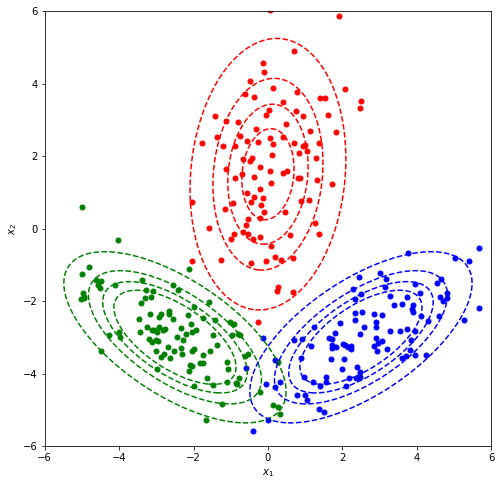

In [5]:
x1_interval = np.linspace(-6, +6, 1201)
x2_interval = np.linspace(-6, +6, 1201)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
X_grid = np.vstack((x1_grid.flatten(), x2_grid.flatten())).T

D1 = stats.multivariate_normal.pdf(X_grid, mean = class_means[0,:],
                                   cov = class_covariances[0,:,:])
D1 = D1.reshape((len(x1_interval), len(x2_interval)))
D2 = stats.multivariate_normal.pdf(X_grid, mean = class_means[1,:],
                                   cov = class_covariances[1,:,:])
D2 = D2.reshape((len(x1_interval), len(x2_interval)))
D3 = stats.multivariate_normal.pdf(X_grid, mean = class_means[2,:],
                                   cov = class_covariances[2,:,:])
D3 = D3.reshape((len(x1_interval), len(x2_interval)))

# plot data points generated
plt.figure(figsize = (8, 8))
plt.plot(points1[:,0], points1[:,1], "r.", markersize = 10)
plt.plot(points2[:,0], points2[:,1], "g.", markersize = 10)
plt.plot(points3[:,0], points3[:,1], "b.", markersize = 10)
plt.contour(x1_grid, x2_grid, D1, levels = [0.01, 0.03, 0.05, 0.07],
            colors = "r", linestyles = "dashed")
plt.contour(x1_grid, x2_grid, D2, levels = [0.01, 0.03, 0.05, 0.07],
            colors = "g", linestyles = "dashed")
plt.contour(x1_grid, x2_grid, D3, levels = [0.01, 0.03, 0.05, 0.07],
            colors = "b", linestyles = "dashed",)
plt.xlim((-6, +6))
plt.ylim((-6, +6))
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

## Importing Data

In [6]:
# read data into memory
data_set = np.genfromtxt("lab04_data_set.csv", delimiter = ",")

# get X and y values
X = data_set[:,[0, 1]]
y_truth = data_set[:,2].astype(int)

# get number of classes and number of samples
K = np.max(y_truth)
N = data_set.shape[0]

# one-of-K encoding
Y_truth = np.zeros((N, K)).astype(int)
Y_truth[range(N), y_truth - 1] = 1

## Softmax Function

$\textrm{softmax}_{c}(\boldsymbol{w}_{c}^{\top} \boldsymbol{x} + w_{c0}) = \dfrac{\exp\left[(\boldsymbol{w}_{c}^{\top} \boldsymbol{x} + w_{c0})\right]}{\sum\limits_{k=1}^{K}\exp\left[(\boldsymbol{w}_{k}^{\top} \boldsymbol{x} + w_{k0})\right]}$

In [7]:
# define the softmax function
def softmax(X, W, w0):
    scores = np.matmul(np.hstack((X, np.ones((N, 1)))), np.vstack((W, w0)))
    scores = np.exp(scores - np.repeat(np.amax(scores, axis = 1, keepdims = True), K, axis = 1))
    scores = scores / np.repeat(np.sum(scores, axis = 1, keepdims = True), K, axis = 1)
    return(scores)

## Gradient Functions

\begin{align*}
\dfrac{\partial \textrm{Error}}{\partial \boldsymbol{w}_{c}} &= -\sum\limits_{i = 1}^{N} (y_{ic} - \widehat{y}_{ic})\boldsymbol{x}_{i} \\
\dfrac{\partial \textrm{Error}}{\partial w_{c0}} &= -\sum\limits_{i = 1}^{N} (y_{ic} - \widehat{y}_{ic}) 
\end{align*}

In [8]:
# define the gradient functions
def gradient_W(X, Y_truth, Y_predicted):
    return(np.asarray([-np.matmul(Y_truth[:,c] - Y_predicted[:,c], X) for c in range(K)]).transpose())

def gradient_w0(Y_truth, Y_predicted):
    return(-np.sum(Y_truth - Y_predicted, axis = 0))

## Algorithm Parameters

In [9]:
# set learning parameters
eta = 0.01
epsilon = 0.001

## Parameter Initialization

In [10]:
# randomly initalize W and w0
np.random.seed(421)
W = np.random.uniform(low = -0.01, high = 0.01, size = (X.shape[1], K))
w0 = np.random.uniform(low = -0.01, high = 0.01, size = (1, K))

## Iterative Algorithm

$\textrm{Error} = -\sum\limits_{i = 1}^{N} \sum\limits_{c = 1}^{K} \left[ y_{ic}\log(\hat{y}_{ic}) \right]$

In [11]:
# learn W and w0 using gradient descent
iteration = 1
objective_values = []
while True:
    Y_predicted = softmax(X, W, w0)

    objective_values = np.append(objective_values, -np.sum(Y_truth * safelog(Y_predicted)))

    W_old = W
    w0_old = w0

    W = W - eta * gradient_W(X, Y_truth, Y_predicted)
    w0 = w0 - eta * gradient_w0(Y_truth, Y_predicted)

    if np.sqrt(np.sum((w0 - w0_old))**2 + np.sum((W - W_old)**2)) < epsilon:
        break

    iteration = iteration + 1
print(W)
print(w0)

[[ 0.1037237  -2.39772825  2.29485191]
 [ 2.05439156 -1.08419634 -0.97415385]]
[[ 5.22247029 -2.95930281 -2.26350865]]


## Convergence

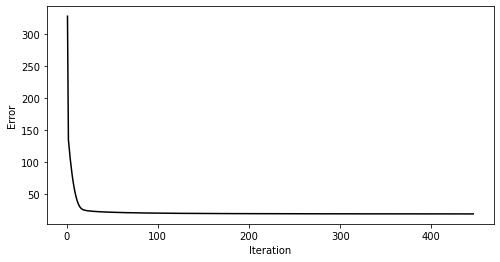

In [12]:
# plot objective function during iterations
plt.figure(figsize = (8, 4))
plt.plot(range(1, iteration + 1), objective_values, "k-")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

## Training Performance

In [13]:
# calculate confusion matrix
y_predicted = np.argmax(Y_predicted, axis = 1) + 1
confusion_matrix = pd.crosstab(y_predicted, y_truth, rownames = ["y_pred"], colnames = ["y_truth"])
print(confusion_matrix)

y_truth   1   2   3
y_pred             
1        99   0   0
2         1  96   3
3         0   4  97


## Visualization

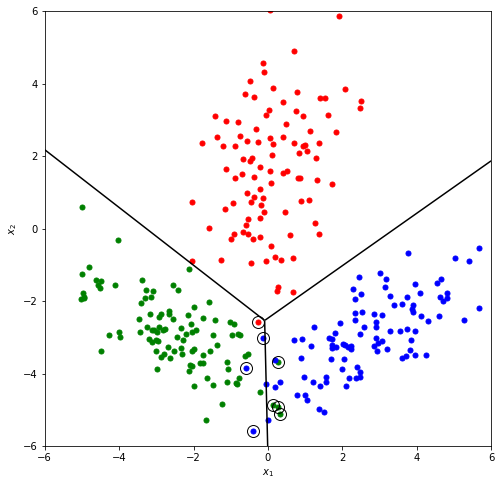

In [14]:
# evaluate discriminant function on a grid
x1_interval = np.linspace(-6, +6, 1201)
x2_interval = np.linspace(-6, +6, 1201)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
discriminant_values = np.zeros((len(x1_interval), len(x2_interval), K))
for c in range(K):
    discriminant_values[:,:,c] = W[0, c] * x1_grid + W[1, c] * x2_grid + w0[0, c]

A = discriminant_values[:,:,0]
B = discriminant_values[:,:,1]
C = discriminant_values[:,:,2]
A[(A < B) & (A < C)] = None
B[(B < A) & (B < C)] = None
C[(C < A) & (C < B)] = None
discriminant_values[:,:,0] = A
discriminant_values[:,:,1] = B
discriminant_values[:,:,2] = C

plt.figure(figsize = (8, 8))
plt.plot(X[y_truth == 1, 0], X[y_truth == 1, 1], "r.", markersize = 10)
plt.plot(X[y_truth == 2, 0], X[y_truth == 2, 1], "g.", markersize = 10)
plt.plot(X[y_truth == 3, 0], X[y_truth == 3, 1], "b.", markersize = 10)
plt.plot(X[y_predicted != y_truth, 0], X[y_predicted != y_truth, 1], "ko", markersize = 12, fillstyle = "none")
plt.contour(x1_grid, x2_grid, discriminant_values[:,:,0] - discriminant_values[:,:,1], levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminant_values[:,:,0] - discriminant_values[:,:,2], levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminant_values[:,:,1] - discriminant_values[:,:,2], levels = 0, colors = "k")
plt.xlim((-6, +6))
plt.ylim((-6, +6))
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()